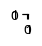

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt

# Load models together
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
%load_ext autoreload
%autoreload 2
    
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.sim_utils import make_dist_matrix
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.multimodal_datasets import MultimodalMarginalLatentDataset
from src.multimodal_models import BSSVAE, JMVAE
from src.multimodal_train_eval import predict_multimodal
from src.metrics import reconstruction_accuracy, VAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180


In [6]:
import networkx as nx

In [7]:
new_df_noswap = pd.read_csv('../data/multimodal/240326_nettcr_paired_NOswaps.csv')
new_df_wswap = pd.read_csv('../data/multimodal/240326_nettcr_paired_withswaps.csv')
new_df_filt = pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_POSONLY.csv')

# fct defs

In [2]:
def get_latent_df(model, df, dataset_params:dict=None):
    
    # Init dataset and pred fct depending on model type
    dataset_params = dict(max_len_a1=7, max_len_a2=8, max_len_a3=22,
                          max_len_b1=6, max_len_b2=7, max_len_b3=23, max_len_pep=0,
                          encoding='BL50LO', pad_scale=-20,
                          a1_col='A1', a2_col='A2', a3_col='A3', b1_col='B1', b2_col='B2', b3_col='B3',
                          pep_col='peptide') if dataset_params is None else dataset_params
    
    if hasattr(model, 'vae'):
        model = model.vae
        if model.max_len>7+8+22+6+7+23:
            dataset_params['max_len_pep']=12
        else:
            dataset_params['max_len_pep']=0
            
    dataset_params['add_positional_encoding'] = model.add_positional_encoding

    if type(model) == FullTCRVAE:
        print(dataset_params)
        dataset = FullTCRDataset(df, **dataset_params)
        dataloader = dataset.get_dataloader(512, SequentialSampler)
        latent_df = predict_model(model, dataset, dataloader)
        
    elif type(model) in [BSSVAE, JMVAE]:
        pred_fct = predict_multimodal
        dataset_params['pair_only'] = True
        dataset_params['return_pair'] = type(model)==JMVAE
        dataset_params['modality']='tcr'
        dataset = MultimodalMarginalLatentDataset(model, df, **dataset_params)
        latent_df = df.copy()
        zdim = dataset.z.shape[1]
        latent_df[[f'z_{i}' for i in range(zdim)]] = dataset.z

    return latent_df

def get_distances_labels_from_latent(latent_df, label_col='peptide', seq_cols= ('A1','A2','A3','B1','B2','B3')):
    # Columns for making distmatrix
    rest_cols = list(x for x in latent_df.columns if x in ['peptide', 'original_peptide','origin', 'binder'])
    # Getting distmatrix and arrays
    dist_matrix = make_dist_matrix(latent_df, label_col, seq_cols, cols=rest_cols)
    dist_array = dist_matrix.iloc[:len(dist_matrix), :len(dist_matrix)].values
    # Getting label encoder and features for computing metrics
    features = latent_df[[z for z in latent_df.columns if z.startswith('z_')]].values
    label_encoder = LabelEncoder()
    labels = latent_df[label_col].values
    encoded_labels = label_encoder.fit_transform(labels)
    return dist_matrix, dist_array, features, labels, encoded_labels, label_encoder

def get_merged_distances_labels(dist_matrix, original_df, index_tcr_df, label_col='peptide', query_subset=None):
    # Assumes a square matrix with no other columns, and that the original_df and index_tcr_df match
    merged = pd.merge(index_tcr_df, original_df[[x for x in original_df.columns if x in['seq_id','peptide','partition','binder','origin','fulltcr']]],
         left_on=['q_index', 'tcr'], right_on=['seq_id','fulltcr'])
    
    assert((merged['seq_id']==merged['q_index']).all() and (merged['tcr']==merged['fulltcr']).all()),'fuck'
    merged = merged.set_index('q_index')[[x for x in merged.columns if x in ['peptide','partition','binder','origin']]]
    merged_dist_matrix = pd.merge(dist_matrix, merged, left_index=True,right_index=True)
    extra_cols = merged_dist_matrix.columns.difference(dist_matrix.columns)
    
    if query_subset is not None:
        query = merged_dist_matrix.query(query_subset)
        merged_dist_matrix = query[list(str(x) for x in query.index)+list(extra_cols)]
    
    return merged_dist_matrix, extra_cols

def get_distances_labels_from_distmatrix(dist_matrix, original_df, index_tcr_df, label_col='peptide', query_subset=None):
    merged_dist_matrix, extra_cols = get_merged_distances_labels(dist_matrix, original_df, index_tcr_df, label_col, query_subset)
    dist_array = merged_dist_matrix.iloc[:,:-len(extra_cols)].values
    features = torch.randn([dist_array.shape[0], 3])
    label_encoder = LabelEncoder()
    labels = merged_dist_matrix[label_col].values
    encoded_labels = label_encoder.fit_transform(labels)
    return merged_dist_matrix, dist_array, features, labels, encoded_labels, label_encoder

def cluster_all_thresholds(dist_array, features, labels, encoded_labels, label_encoder,
                           decimals=5, n_points=1500):
    # Getting clustering at all thresholds
    limits = get_linspace(dist_array, decimals, n_points)
    results = []
    for t in tqdm(limits):
        c = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold=t, linkage='complete')
        c.fit(dist_array)
        results.append(get_all_metrics(t, features, c, dist_array, labels, encoded_labels, label_encoder))
    results = pd.DataFrame(results)
    results['retention'] = (dist_array.shape[0]-results['n_singletons']) / dist_array.shape[0]
    return results

In [3]:
def get_model(folder, map_location='cpu'):
    pt = glob.glob(folder+'/*checkpoint_best*.pt')
    pt = [x for x in pt if 'interval' not in x][0]
    js = glob.glob(folder+'/*checkpoint*.json')[0]
    model = load_model_full(pt, js, map_location='cpu')
    # Extract the vae part if the model comes from a two stage VAE
    if type(model)==TwoStageVAECLF:
        model = model.vae
    model.eval()
    return model


def get_purity(counts):
    # Purity in absolute % of a cluster, taking the majority label 
    # high = better
    sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
    return sorted_counts[list(sorted_counts.keys())[0]] / sum(sorted_counts.values())
    
def get_mixity(counts):
    # how many different labels are inside a cluster, weighted by the number of members
    # low = better
    return len(counts.keys()) / sum(counts.values())
    
def get_coherence(dist_array):
    # Assumes dist_array is the subset of the distance array for a given cluster label
    # mean distance within a cluster
    # low = better

    # get upper triangle mask without the diagonale
    mask = np.triu(np.ones(dist_array.shape), k=0) - np.eye(dist_array.shape[0])
    flat_array = dist_array[mask==1]
    return np.mean(flat_array)

def get_purity_mixity_coherence(cluster_label:int, 
                                true_labels:list, 
                                pred_labels:list, 
                                dist_array:np.array,
                                label_encoder):
    """
        For a given cluster label (int) returned by clustering.labels_, 
        Return the purity, mixity, coherence, cluster_size, and scale (==cluster_size/total_size)
        scale should be used to get a weighted average metric at the end
    """
    indices = np.where(pred_labels==cluster_label)[0]
    cluster_size = len(indices)
    if cluster_size<=1:
        # return np.nan, np.nan, np.nan, 1, 1/len(true_labels)
        return {'purity':np.nan, 'coherence':np.nan, 'cluster_size':1}

    # Query the subset of the true labels belonging to this cluster using indices 
    # Convert to int label encodings in order to use np.bincount to get purity and mixity
    subset = true_labels[indices]
    encoded_subset = label_encoder.transform(subset)
    counts = {i:k for i,k in enumerate(np.bincount(encoded_subset)) if k>0}
    purity = get_purity(counts)
    # mixity = get_mixity(counts)
    # index the distance matrix and return the mean distance within this cluster (i.e. coherence)
    coherence = get_coherence(dist_array[indices][:, indices])
    
    # return purity, mixity, coherence, cluster_size, cluster_size / len(true_labels)
    return {'purity':purity, 'coherence':coherence, 'cluster_size':cluster_size}

def get_all_metrics(t, features, c, array, true_labels, encoded_labels, label_encoder):
    n_cluster = np.sum((np.bincount(c.labels_)>1))
    n_singletons = (np.bincount(c.labels_)==1).sum()
    try:
        s_score = silhouette_score(features, c.labels_, metric='cosine')
    except:
        s_score = np.nan
    try:
        c_score = ch_score(features, c.labels_)
    except:
        c_score = np.nan
    try:
        d_score = db_score(features, c.labels_)
    except:
        d_score = np.nan
    try:
        ari_score = adjusted_rand_score(encoded_labels, c.labels_)
    except:
        ari_score = np.nan
    
    xd = pd.concat([pd.DataFrame(get_purity_mixity_coherence(k, true_labels, c.labels_, array, label_encoder), index=[0])
                    for k in set(c.labels_)]).dropna()
    mean_purity = xd['purity'].mean()
    mean_coherence = xd['coherence'].mean()
    mean_cs = xd['cluster_size'].mean()
    nc_07 = len(xd.query('purity>=0.7'))
    return {'threshold':t, 
            'n_cluster':n_cluster, 'n_singletons':n_singletons,
            'n_cluster_over_70p':nc_07,
            'mean_purity':xd['purity'].mean(), 
            'min_purity':xd['purity'].min(), 
            'max_purity':xd['purity'].max(), 
            'mean_coherence':xd['coherence'].mean(), 
            'min_coherence':xd['coherence'].min(), 
            'max_coherence':xd['coherence'].max(), 
            'mean_cluster_size': xd['cluster_size'].mean(),
            'min_cluster_size': xd['cluster_size'].min(),
            'max_cluster_size': xd['cluster_size'].max(),
            'silhouette':s_score,
            'ch_index':c_score, 'db_index':d_score, 'ARI':ari_score}

def get_bounds(array, decimals=5):
    lower_bound = array[array>0].min()
    upper_bound = array.max()
    factor = 10 ** decimals
    return np.floor(lower_bound * factor)/factor, np.ceil(upper_bound*factor)/factor


def get_linspace(array, decimals=5, n_points=1500):
    return np.round(np.linspace(*get_bounds(array, decimals), n_points), decimals)

In [4]:
def vae_clustering_pipeline(model_folder, input_df, name, dataset_params=None, n_points=500):
    model = get_model(model_folder, map_location='cpu')
    latent_df = get_latent_df(model, input_df, dataset_params)
    dist_matrix, dist_array, features, labels, encoded_labels, label_encoder = get_distances_labels(latent_df)
    results = cluster_all_thresholds(dist_array, features, labels, encoded_labels, label_encoder, n_points=n_points)
    results['input_type'] = name
    return results

def plot_pipeline(results, b, plot_title = 'None', fig_fn = None, filter=None, palette=None, more=False, add_cluster_size=False):
    runs = pd.concat([b, results])
    # plotting options
    if filter is None:
        filter = ['TBCRalign', 'KernelSim', 'tcrdist3'] + list(results.input_type.unique())

    if palette is None:
        palette='gnuplot2'
    if more:
        palette = get_palette(palette, n_colors=len(filter)-3)
    else:
        palette = sns.color_palette(palette, n_colors=len(filter)-3)

    sns.set_palette(palette)
    f,a = plt.subplots(1, 1, figsize=(9,9))
    a.set_xlim([0,1])
    a.set_ylim([0,1])
    a.set_xlabel('Retention', fontweight='semibold', fontsize=14)
    a.set_ylabel('Avg Purity', fontweight='semibold', fontsize=14)
    # Setting major ticks
    major_ticks = np.arange(0, 1.1, 0.1)
    a.set_xticks(major_ticks)
    a.set_yticks(major_ticks)
    # Setting minor ticks
    minor_ticks = np.arange(0, 1.1, 0.05)
    a.set_xticks(minor_ticks, minor=True)
    a.set_yticks(minor_ticks, minor=True)
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    print(runs.duplicated().any())
    if add_cluster_size:
        ax2 = a.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_yscale('log', base=2)
        
    for i, input_type in enumerate(filter):
        query = runs.query('input_type==@input_type')
        retentions = query['retention'].values[1:-1]
        purities = query['mean_purity'].values[1:-1]
        print(input_type, '\t', round(get_retpur_auc(retentions, purities),4))
        ls = '-' if i%2==0 else '--'
        if add_cluster_size:
            cluster_sizes = query['mean_cluster_size'].values[1:-1]
        # Plotting baselines with fixed styles colors etc
        if input_type=="TBCRalign":
            a.plot(retentions, purities, label='TBCRalign', ls=':', c='k', lw=1.)
            if add_cluster_size:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='x', lw=0.5, s=8, c='k')
        elif input_type=="KernelSim":
            a.plot(retentions, purities, label='KernelSim', ls=':', c='m', lw=1.)
            if add_cluster_size:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='v', lw=0.1, s=8, c='m')
        elif input_type=="tcrdist3":
            a.plot(retentions, purities, label='tcrdist3', ls=':', c='y', lw=1.)
            if add_cluster_size:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='*', lw=0.1, s=8, c='y')
        # Plotting the actual things
        else:
            a.plot(retentions, purities, label=input_type.lstrip('_').replace('_',' ').replace('checkpoint best',''), ls=ls, lw=1.)
            if add_cluster_size:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='+', lw=1.15, s=12)
        
    a.axhline(0.6, label='60% purity cut-off', ls=':', lw=.75, c='m')
    a.axhline(0.7, label='70% purity cut-off', ls=':', lw=.75, c='c')
    a.axhline(0.8, label='80% purity cut-off', ls=':', lw=.75, c='y')
    
    a.legend(title='distance matrix', title_fontproperties={'size':14, 'weight':'semibold'}, prop={'weight':'semibold','size':12})

    

    
    f.suptitle(f'{plot_title}', fontweight='semibold', fontsize=15)
    f.tight_layout()
    if fig_fn is not None:
        f.savefig(f'../output/240411_ClusteringTests/{fig_fn}.png', dpi=200)
    return runs

In [5]:
def plot_curve_clustersizes(run, filter=None):
    if filter is None:
        filter = run.input_type.unique()
    else:
        if ['TBCRalign'] not in filter:
            filter = ['TBCRalign']+filter
        if ['tcrdist3'] not in filter:
            filter = ['tcrdist3']+filter
            
    sns.set_palette('gnuplot2', n_colors=len(filter)-2)
    f,a = plt.subplots(1, 1, figsize=(13,9))
    a.set_xlim([0,1])
    a.set_ylim([0,1])
    a.set_xlabel('Retention', fontweight='semibold', fontsize=14)
    a.set_ylabel('Avg Purity', fontweight='semibold', fontsize=14)
    # Setting major ticks
    major_ticks = np.arange(0, 1.1, 0.1)
    a.set_xticks(major_ticks)
    a.set_yticks(major_ticks)
    # Setting minor ticks
    minor_ticks = np.arange(0, 1.1, 0.05)
    a.set_xticks(minor_ticks, minor=True)
    a.set_yticks(minor_ticks, minor=True)
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    ax2 = a.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_yscale('log', base=2)
    
    markers = ['*', '.', '+', 'h', 's', '3', 'v', 'o', 'x', 'p']
    print(len(filter))
    for i,input_type in enumerate(filter):
        query = run.query('input_type==@input_type')
        retentions = query['retention'].values
        purities = query['mean_purity'].values
        clustersizes = query['mean_cluster_size']
        if input_type=="TBCRalign":
            a.plot(retentions, purities, label=input_type.lstrip('_'), ls='-.', c='g', lw=1.)
            ax2.scatter(retentions, clustersizes, label=input_type.lstrip('_'), marker='x', lw=0.5, s=8, c='g')
        elif input_type=="tcrdist3":
            a.plot(retentions, purities, label=input_type.lstrip('_'), ls='-.', c='y', lw=1.)
            ax2.scatter(retentions, clustersizes, label=input_type.lstrip('_'), marker='v', lw=0.1, s=8, c='y')
        else:
            a.plot(retentions, purities, label=input_type.lstrip('_'), ls='--', lw=1.)
            ax2.scatter(retentions, clustersizes, label=input_type.lstrip('_'), marker='+', lw=1.15, s=12)
        
    a.axhline(0.6, label='60% purity cut-off', ls=':', lw=.75, c='m')
    a.axhline(0.7, label='70% purity cut-off', ls=':', lw=.75, c='c')
    a.axhline(0.8, label='80% purity cut-off', ls=':', lw=.75, c='y')
    
    a.legend(title='distance matrix', bbox_to_anchor=(1.1, 0.85),
             title_fontproperties={'size':14, 'weight':'semibold'}, prop={'weight':'semibold','size':12})
    
    ax2.legend(title='Mean cluster size', bbox_to_anchor=(1.1, 0.35),
             title_fontproperties={'size':14, 'weight':'semibold'}, prop={'weight':'semibold','size':12})
    
    f.tight_layout()

# reload baselines

In [31]:
new_df_noswap['tcr'] = new_df_noswap['A1']+new_df_noswap['A2']+new_df_noswap['A3']+new_df_noswap['B1']+new_df_noswap['B2']+new_df_noswap['B3']

In [ ]:
old_df = pd.read_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv').query('binder==1').reset_index(drop=True)
new_df = pd.read_csv('../data/multimodal/240326_nettcr_paired_withswaps.csv').query('binder==1').reset_index(drop=True)
old_df['seq_id'] = range(len(old_df))
new_df['seq_id'] = range(len(new_df))
# saving split CDRs for tbcr_alignas

In [11]:
# TBCR
tbcr_dm140 = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/OUTPUT_tbcralign_distmatrix_140peps.csv', index_col=0)
tcr_index140 = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/OUTPUT_index_tcrs_140pep.txt')
tbcr_dm, _, _, _, _, _ = get_distances_labels_from_distmatrix(tbcr_dm140, new_df_noswap, tcr_index140, label_col='peptide', 
                                                              query_subset='partition != 6')

tbcr_dm140_labeled = tbcr_dm140.merge(new_df_noswap.set_index('tcr').merge(tcr_index140.set_index('tcr'), left_index=True, right_index=True).drop_duplicates(['q_index']).reset_index().set_index('q_index')[['peptide','original_peptide','binder','partition', 'raw_index']],
                                      left_index=True, right_index=True)
tbcr_dm140_labeled.to_csv('../output/240411_ClusteringTests/dist_matrices/2404XX_OUTPUT_tbcralign_distmatrix_140peps_labeled.csv')
tbcr_dm140_part0 = tbcr_dm140_labeled.query('partition==0 and peptide in @new_df_filt.peptide.unique()')
tbcr_dm140_part0 = tbcr_dm140_part0[[str(x) for x in tbcr_dm140_part0.index.to_list()] + ['peptide','binder','partition','raw_index']]
# tbcr = cluster_all_thresholds(dist_array, features, labels, encoded_labels, label_encoder, n_points=500)
# tbcr['input_type'] = 'TBCRalign'
# baselines_valid.append(tbcr)

KeyError: 'seq_id'

In [71]:
# Kernel
kernel_dm140 = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/OUTPUT_distmatrix_kernelsim_140peps_labelled.csv')
kernel_dm140_part0 = kernel_dm140.query('partition==0 and peptide in @new_df_filt.peptide.unique()')
kernel_dm140_part0 = kernel_dm140_part0[kernel_dm140_part0['db'].to_list() + ['origin', 'peptide', 'binder', 'partition']]

In [73]:
del dm_140, dm_140_part0

In [72]:
tbcr_array = tbcr_dm140_part0.iloc[:len(tbcr_dm140_part0), :len(tbcr_dm140_part0)].values
ker_array = kernel_dm140_part0.iloc[:len(kernel_dm140_part0), :len(kernel_dm140_part0)].values

In [74]:
tcrdist3_newfilt = pkl_load('../output/240411_ClusteringTests/dist_matrices/240422_new_df_filt_tcrdist3.csv')
id_newfilt = pd.read_csv('../output/240411_ClusteringTests/240422_new_df_filt_tcrdist3_LABELS.csv').drop(columns=['Unnamed: 0'])
id_newfilt_validonly = id_newfilt.query('partition==0')
labels_newfilt_validonly = id_newfilt_validonly['peptide'].values
tcrdist_array = tcrdist3_newfilt[id_newfilt_validonly.index][:, id_newfilt_validonly.index]

# Minimum spanning trees

In [ ]:
# Get combined model by taking the dist matrix for tbcr and model and do 1-dist then multiply and do 1- (mult)

In [ ]:
# Using that best cos model
model = get_model('../output/240404_TCRONLY_onetwostage_smallLARGE/240404_2342_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_SmCosTCRP1/

In [ ]:
g = nx.Graph(a